In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: 


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

In [5]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [6]:
len(df_data)

5785

In [7]:
# df_cov = pd.read_csv(data_folder+'covsys_000.txt', sep='\\n')
# df_cov.head()

In [8]:
# cov = df_cov.values
# len(cov)

In [9]:
# cov = cov.reshape((len(df_data), len(df_data)))
# np.shape(cov)

In [10]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


No handles with labels found to put in legend.


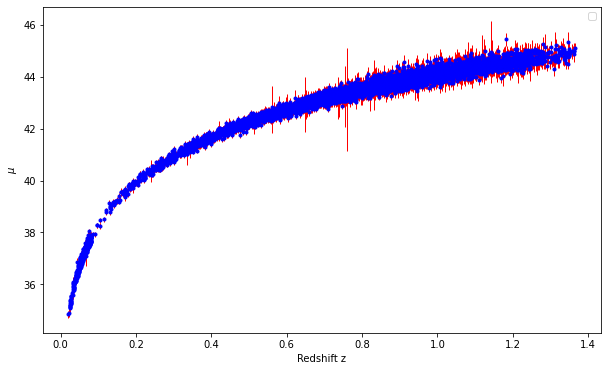

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['errors'].values, fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [12]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [13]:
len(df_data)

5785

In [14]:
df_data.head()

,zCMB,MU,errors
0,0.01988,34.84680,0.13996
1,0.02321,34.89863,0.16230
2,0.02364,35.28915,0.13201
3,0.02470,35.11988,0.15157
4,0.02471,35.19347,0.13022


In [15]:
z = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values

randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [16]:
zmin, zmax = np.min(z), np.max(z)
zmin, zmax

(0.019880000000000002, 1.36643)

No handles with labels found to put in legend.


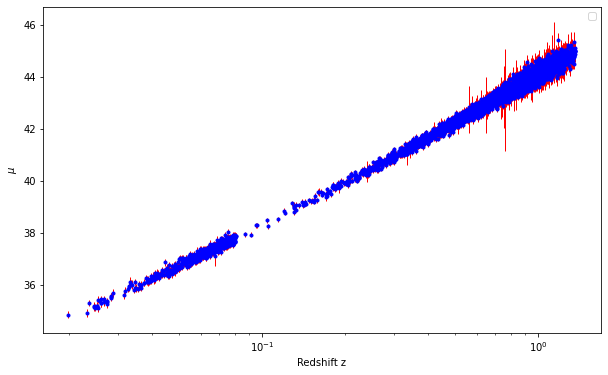

In [17]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.xscale('log')
plt.legend()

In [18]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [19]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [20]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [21]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((4630,), (4632,), (1157, 1), (1157, 1))

In [22]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 32
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[200, 200,200,200])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               400       
                                                                 
 MCDropout_1 (MCDropout)     (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_3 (MCDropout)     (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               4

In [23]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/2000
145/145 [==============================] - 1s 4ms/step - loss: 738.5731 - val_loss: 239.9558
Epoch 2/2000
145/145 [==============================] - 0s 3ms/step - loss: 138.3992 - val_loss: 81.7965
Epoch 3/2000
145/145 [==============================] - 0s 2ms/step - loss: 46.8597 - val_loss: 18.2208
Epoch 4/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.6488 - val_loss: 5.6394
Epoch 5/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.2036 - val_loss: 5.1782
Epoch 6/2000
145/145 [==============================] - 0s 2ms/step - loss: 4.9994 - val_loss: 5.0378
Epoch 7/2000
145/145 [==============================] - 0s 2ms/step - loss: 4.7648 - val_loss: 4.9665
Epoch 8/2000
145/145 [==============================] - 0s 2ms/step - loss: 4.5623 - val_loss: 4.5957
Epoch 9/2000
145/145 [==============================] - 0s 2ms/step - loss: 4.5413 - val_loss: 4.2705
Epoch 10/2000
145/145 [==============================] - 0s 2ms/step - lo

145/145 [==============================] - 0s 3ms/step - loss: 1.9604 - val_loss: 1.9447
Epoch 81/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.9461 - val_loss: 1.9664
Epoch 82/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.9224 - val_loss: 1.7879
Epoch 83/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.9336 - val_loss: 1.9741
Epoch 84/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.8938 - val_loss: 1.9535
Epoch 85/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.8914 - val_loss: 1.8221
Epoch 86/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.9216 - val_loss: 1.8140
Epoch 87/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.9502 - val_loss: 1.8368
Epoch 88/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.8983 - val_loss: 1.7946
Epoch 89/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.8935 - v

145/145 [==============================] - 0s 3ms/step - loss: 1.5214 - val_loss: 1.5506
Epoch 160/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.5010 - val_loss: 1.5336
Epoch 161/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.5727 - val_loss: 1.6061
Epoch 162/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.5065 - val_loss: 1.4939
Epoch 163/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.5373 - val_loss: 1.4192
Epoch 164/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.5055 - val_loss: 1.5975
Epoch 165/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.5262 - val_loss: 1.5504
Epoch 166/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.5183 - val_loss: 1.5581
Epoch 167/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.4476 - val_loss: 1.4494
Epoch 168/2000
145/145 [==============================] - 0s 3ms/step - loss: 1

Epoch 238/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3314 - val_loss: 1.3557
Epoch 239/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3590 - val_loss: 1.3985
Epoch 240/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3631 - val_loss: 1.2774
Epoch 241/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3415 - val_loss: 1.3921
Epoch 242/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3366 - val_loss: 1.4128
Epoch 243/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3244 - val_loss: 1.2749
Epoch 244/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2768 - val_loss: 1.3145
Epoch 245/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.3268 - val_loss: 1.2529
Epoch 246/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3123 - val_loss: 1.2427
Epoch 247/2000
145/145 [==============================] - 0s 3ms

Epoch 317/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2568 - val_loss: 1.2032
Epoch 318/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2574 - val_loss: 1.2634
Epoch 319/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2697 - val_loss: 1.3096
Epoch 320/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2228 - val_loss: 1.2297
Epoch 321/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2192 - val_loss: 1.2688
Epoch 322/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2762 - val_loss: 1.2713
Epoch 323/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2708 - val_loss: 1.1599
Epoch 324/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2562 - val_loss: 1.2606
Epoch 325/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2545 - val_loss: 1.1794
Epoch 326/2000
145/145 [==============================] - 0s 3ms

Epoch 396/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1468 - val_loss: 1.1643
Epoch 397/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1808 - val_loss: 1.3290
Epoch 398/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2479 - val_loss: 1.1383
Epoch 399/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.2184 - val_loss: 1.1673
Epoch 400/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1388 - val_loss: 1.1519
Epoch 401/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1743 - val_loss: 1.2399
Epoch 402/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1866 - val_loss: 1.1147
Epoch 403/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1213 - val_loss: 1.1781
Epoch 404/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1973 - val_loss: 1.1250
Epoch 405/2000
145/145 [==============================] - 0s 3ms

Epoch 475/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1067 - val_loss: 1.1728
Epoch 476/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1051 - val_loss: 1.1345
Epoch 477/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1284 - val_loss: 1.1171
Epoch 478/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1084 - val_loss: 1.1611
Epoch 479/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1324 - val_loss: 1.0911
Epoch 480/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0972 - val_loss: 1.1154
Epoch 481/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1076 - val_loss: 1.1729
Epoch 482/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1543 - val_loss: 1.1602
Epoch 483/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.1173 - val_loss: 1.1377
Epoch 484/2000
145/145 [==============================] - 0s 3ms

Epoch 554/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0471 - val_loss: 1.0901
Epoch 555/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0384 - val_loss: 1.0928
Epoch 556/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0394 - val_loss: 1.0886
Epoch 557/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0622 - val_loss: 1.0868
Epoch 558/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0302 - val_loss: 1.0656
Epoch 559/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0970 - val_loss: 0.9565
Epoch 560/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0098 - val_loss: 1.0893
Epoch 561/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0938 - val_loss: 1.0607
Epoch 562/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0203 - val_loss: 1.0660
Epoch 563/2000
145/145 [==============================] - 0s 3ms

Epoch 633/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0143 - val_loss: 1.0073
Epoch 634/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0198 - val_loss: 1.0130
Epoch 635/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0082 - val_loss: 1.0255
Epoch 636/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0235 - val_loss: 1.0090
Epoch 637/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0139 - val_loss: 1.0882
Epoch 638/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0279 - val_loss: 1.0712
Epoch 639/2000
145/145 [==============================] - 0s 3ms/step - loss: 1.0047 - val_loss: 0.9714
Epoch 640/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9729 - val_loss: 1.0138
Epoch 641/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9739 - val_loss: 0.9504
Epoch 642/2000
145/145 [==============================] - 0s 3ms

Epoch 712/2000
145/145 [==============================] - 1s 4ms/step - loss: 0.9308 - val_loss: 1.0125
Epoch 713/2000
145/145 [==============================] - 1s 4ms/step - loss: 0.9577 - val_loss: 0.8738
Epoch 714/2000
145/145 [==============================] - 1s 4ms/step - loss: 0.9977 - val_loss: 0.9154
Epoch 715/2000
145/145 [==============================] - 1s 4ms/step - loss: 0.9296 - val_loss: 0.9524
Epoch 716/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9453 - val_loss: 0.9297
Epoch 717/2000
145/145 [==============================] - 1s 3ms/step - loss: 0.9670 - val_loss: 0.9314
Epoch 718/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9654 - val_loss: 0.9915
Epoch 719/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9386 - val_loss: 0.9104
Epoch 720/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8964 - val_loss: 0.9642
Epoch 721/2000
145/145 [==============================] - 0s 3ms

Epoch 791/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9133 - val_loss: 0.9366
Epoch 792/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9094 - val_loss: 0.9299
Epoch 793/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8919 - val_loss: 0.8865
Epoch 794/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9219 - val_loss: 0.8919
Epoch 795/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8963 - val_loss: 0.9288
Epoch 796/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8814 - val_loss: 0.9375
Epoch 797/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8809 - val_loss: 0.9101
Epoch 798/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9235 - val_loss: 0.8733
Epoch 799/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.9194 - val_loss: 0.8541
Epoch 800/2000
145/145 [==============================] - 0s 3ms

Epoch 870/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8628 - val_loss: 0.8056
Epoch 871/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8823 - val_loss: 0.9211
Epoch 872/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8398 - val_loss: 0.8135
Epoch 873/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8643 - val_loss: 0.8488
Epoch 874/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8282 - val_loss: 0.8854
Epoch 875/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8549 - val_loss: 0.8804
Epoch 876/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8510 - val_loss: 0.8902
Epoch 877/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8363 - val_loss: 0.8409
Epoch 878/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8819 - val_loss: 0.8634
Epoch 879/2000
145/145 [==============================] - 0s 3ms

Epoch 949/2000
145/145 [==============================] - 1s 4ms/step - loss: 0.8484 - val_loss: 0.8380
Epoch 950/2000
145/145 [==============================] - 1s 6ms/step - loss: 0.8066 - val_loss: 0.9024
Epoch 951/2000
145/145 [==============================] - 1s 5ms/step - loss: 0.8216 - val_loss: 0.7649
Epoch 952/2000
145/145 [==============================] - 1s 6ms/step - loss: 0.8186 - val_loss: 0.7629
Epoch 953/2000
145/145 [==============================] - 1s 5ms/step - loss: 0.8299 - val_loss: 0.8145
Epoch 954/2000
145/145 [==============================] - 1s 4ms/step - loss: 0.8296 - val_loss: 0.8277
Epoch 955/2000
145/145 [==============================] - 1s 3ms/step - loss: 0.7935 - val_loss: 0.8503
Epoch 956/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8401 - val_loss: 0.8079
Epoch 957/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8328 - val_loss: 0.7961
Epoch 958/2000
145/145 [==============================] - 0s 3ms

145/145 [==============================] - 0s 3ms/step - loss: 0.8187 - val_loss: 0.8373
Epoch 1028/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8168 - val_loss: 0.7763
Epoch 1029/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7947 - val_loss: 0.7978
Epoch 1030/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7948 - val_loss: 0.8343
Epoch 1031/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8019 - val_loss: 0.8643
Epoch 1032/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8550 - val_loss: 0.7696
Epoch 1033/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7972 - val_loss: 0.8283
Epoch 1034/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8088 - val_loss: 0.8180
Epoch 1035/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8098 - val_loss: 0.7725
Epoch 1036/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.7852 - val_loss: 0.8342
Epoch 1106/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7952 - val_loss: 0.8389
Epoch 1107/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7835 - val_loss: 0.7595
Epoch 1108/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7719 - val_loss: 0.8252
Epoch 1109/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7919 - val_loss: 0.7852
Epoch 1110/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8056 - val_loss: 0.7595
Epoch 1111/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7979 - val_loss: 0.6995
Epoch 1112/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7862 - val_loss: 0.8188
Epoch 1113/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8170 - val_loss: 0.7175
Epoch 1114/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.7864 - val_loss: 0.8157
Epoch 1184/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7652 - val_loss: 0.7550
Epoch 1185/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7608 - val_loss: 0.7723
Epoch 1186/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7802 - val_loss: 0.7084
Epoch 1187/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7901 - val_loss: 0.8066
Epoch 1188/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7710 - val_loss: 0.8027
Epoch 1189/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7499 - val_loss: 0.7376
Epoch 1190/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.8032 - val_loss: 0.7573
Epoch 1191/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7839 - val_loss: 0.7758
Epoch 1192/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.7547 - val_loss: 0.7147
Epoch 1262/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7964 - val_loss: 0.7852
Epoch 1263/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7595 - val_loss: 0.7043
Epoch 1264/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7677 - val_loss: 0.7377
Epoch 1265/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7907 - val_loss: 0.7119
Epoch 1266/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7749 - val_loss: 0.7147
Epoch 1267/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7741 - val_loss: 0.7875
Epoch 1268/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7698 - val_loss: 0.7538
Epoch 1269/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7612 - val_loss: 0.7857
Epoch 1270/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.7628 - val_loss: 0.7682
Epoch 1340/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7550 - val_loss: 0.7198
Epoch 1341/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7337 - val_loss: 0.7935
Epoch 1342/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7235 - val_loss: 0.7149
Epoch 1343/2000
145/145 [==============================] - 1s 4ms/step - loss: 0.7597 - val_loss: 0.7463
Epoch 1344/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7279 - val_loss: 0.7534
Epoch 1345/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7473 - val_loss: 0.7675
Epoch 1346/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7455 - val_loss: 0.7651
Epoch 1347/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7427 - val_loss: 0.7892
Epoch 1348/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.7519 - val_loss: 0.7907
Epoch 1418/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7316 - val_loss: 0.7770
Epoch 1419/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7072 - val_loss: 0.7182
Epoch 1420/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7664 - val_loss: 0.6839
Epoch 1421/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7200 - val_loss: 0.7349
Epoch 1422/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7593 - val_loss: 0.7370
Epoch 1423/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7512 - val_loss: 0.7388
Epoch 1424/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7380 - val_loss: 0.7222
Epoch 1425/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7544 - val_loss: 0.7362
Epoch 1426/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.7688 - val_loss: 0.7040
Epoch 1496/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7177 - val_loss: 0.7080
Epoch 1497/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7036 - val_loss: 0.6957
Epoch 1498/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7629 - val_loss: 0.8106
Epoch 1499/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7409 - val_loss: 0.7065
Epoch 1500/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7372 - val_loss: 0.7048
Epoch 1501/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7251 - val_loss: 0.7183
Epoch 1502/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7387 - val_loss: 0.7606
Epoch 1503/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7056 - val_loss: 0.7015
Epoch 1504/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.7270 - val_loss: 0.7796
Epoch 1574/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7099 - val_loss: 0.7492
Epoch 1575/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7141 - val_loss: 0.6873
Epoch 1576/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7045 - val_loss: 0.6881
Epoch 1577/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7157 - val_loss: 0.7214
Epoch 1578/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7390 - val_loss: 0.7132
Epoch 1579/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7076 - val_loss: 0.7308
Epoch 1580/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7214 - val_loss: 0.7365
Epoch 1581/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6917 - val_loss: 0.7681
Epoch 1582/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.7255 - val_loss: 0.6981
Epoch 1652/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7369 - val_loss: 0.7041
Epoch 1653/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6920 - val_loss: 0.6796
Epoch 1654/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7059 - val_loss: 0.6957
Epoch 1655/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7261 - val_loss: 0.7593
Epoch 1656/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7104 - val_loss: 0.6724
Epoch 1657/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7104 - val_loss: 0.6518
Epoch 1658/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7297 - val_loss: 0.6671
Epoch 1659/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6819 - val_loss: 0.7191
Epoch 1660/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.7108 - val_loss: 0.7239
Epoch 1730/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7062 - val_loss: 0.7055
Epoch 1731/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.7545
Epoch 1732/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7229 - val_loss: 0.7507
Epoch 1733/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7115 - val_loss: 0.6812
Epoch 1734/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7329 - val_loss: 0.7159
Epoch 1735/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7026 - val_loss: 0.7256
Epoch 1736/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7068 - val_loss: 0.7221
Epoch 1737/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7234 - val_loss: 0.6887
Epoch 1738/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.6901 - val_loss: 0.6649
Epoch 1808/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6860 - val_loss: 0.7007
Epoch 1809/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6921 - val_loss: 0.7206
Epoch 1810/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7219 - val_loss: 0.6756
Epoch 1811/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6993 - val_loss: 0.6706
Epoch 1812/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7013 - val_loss: 0.6845
Epoch 1813/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6939 - val_loss: 0.6728
Epoch 1814/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7025 - val_loss: 0.6893
Epoch 1815/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7057 - val_loss: 0.6899
Epoch 1816/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.6556 - val_loss: 0.6845
Epoch 1886/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6965 - val_loss: 0.6901
Epoch 1887/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6920 - val_loss: 0.7342
Epoch 1888/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6896 - val_loss: 0.6929
Epoch 1889/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6854 - val_loss: 0.6952
Epoch 1890/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6999 - val_loss: 0.6964
Epoch 1891/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6718 - val_loss: 0.6921
Epoch 1892/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6849 - val_loss: 0.6893
Epoch 1893/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6940 - val_loss: 0.6542
Epoch 1894/2000
145/145 [==============================] - 0s 3ms/step 

145/145 [==============================] - 0s 3ms/step - loss: 0.6825 - val_loss: 0.6831
Epoch 1964/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6894 - val_loss: 0.7322
Epoch 1965/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.7099 - val_loss: 0.6793
Epoch 1966/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6784 - val_loss: 0.7065
Epoch 1967/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6632 - val_loss: 0.6964
Epoch 1968/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6903 - val_loss: 0.6293
Epoch 1969/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6696 - val_loss: 0.7632
Epoch 1970/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6959 - val_loss: 0.6518
Epoch 1971/2000
145/145 [==============================] - 0s 3ms/step - loss: 0.6560 - val_loss: 0.6714
Epoch 1972/2000
145/145 [==============================] - 0s 3ms/step 

In [24]:
model_train.history['val_loss'][-1]

0.6565977334976196

(0.0, 50.0)

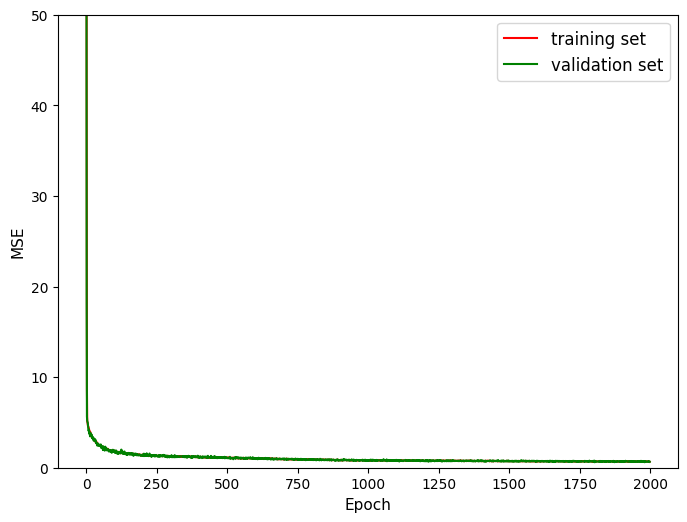

In [25]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 50)

In [26]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(zmin, zmax, test_batch_size)

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 1ms/step


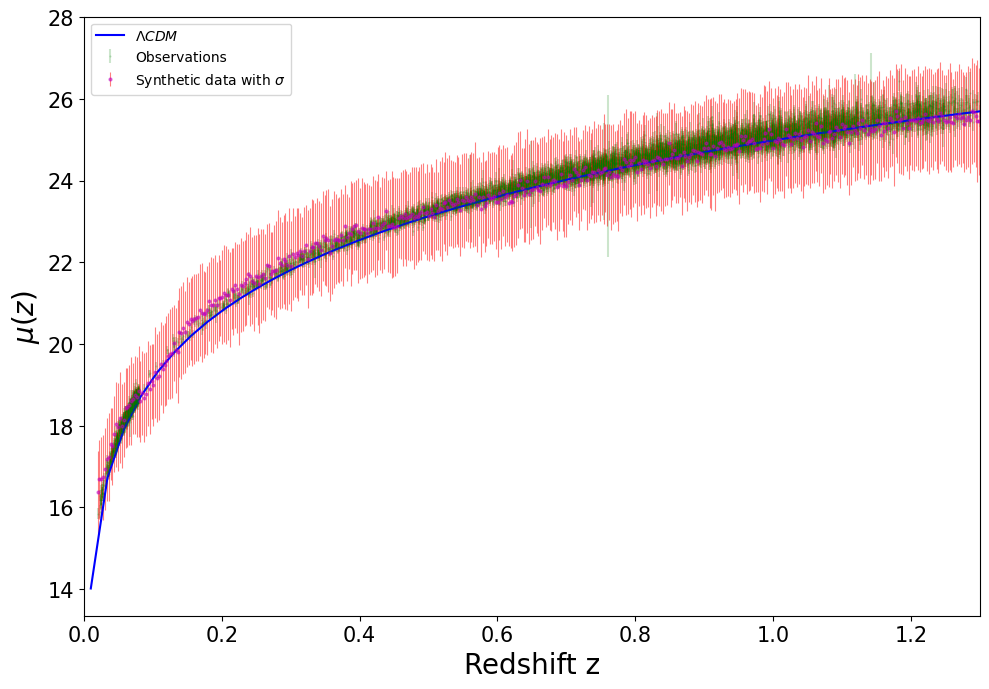

In [27]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors

In [29]:
model.save('models/large_lsst_model.h5')